# Install Dependencies

In [1]:
!nvidia-smi

Fri Apr 29 14:48:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   43C    P5    27W / 320W |   1544MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import packages

In [2]:
from functools import partial
from datetime import datetime
# from pytz import timezone
from models_vgg16 import model_build, IntervalEval, compute_metrics, model_build_finetune
from utils_vgg16 import parse_example
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
import shutil
import os
os.environ['TF_CUDNN_DETERMINISTIC']='1'

## Parameter setting

In [3]:
# Do not change these params
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = (227, 227, 3)
TEST_SIZE = 0.1 

# Directory and Model name
MODEL_NAME = 'vgg16' #@param ["densenet121", "resnet50", "vgg16"]{type:"raw"}
DATA_DIR = 'tfrecords'
MODEL_DIR = 'models'
TB_DIR = 'tensorboard'

## Parameters for Turning ##
LR = 0.0001 #@param {type:"slider", min:1e-4, max:1e-3, step:1e-4}
NUM_EPOCHS = 6 #@param {type:"slider", min:5, max:15, step:1}
DROP_OUT = 0.2 #@param {type:"slider", min:0, max:0.5, step:0.05}
OHEM_RATE = 0.5 #@param {type:"slider", min:0.1, max:0.8, step:0.1}
DATA_AUG = True #@param {type:"boolean"}
CV_MODE = False #@param {type:"boolean"}
config_num = 1

# set tensorflow global random seed
tf.random.set_seed(1234)

## How does one tfrecord look like?
Data augmentation will include:
* 50% original
* 25% cut out (100*100 zero mask)
* 25% random flip and rotation

In [4]:
eda_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, 'shard100_32.tfrecord')])
eda_dataset = eda_dataset.map(partial(parse_example, data_aug=DATA_AUG, shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)

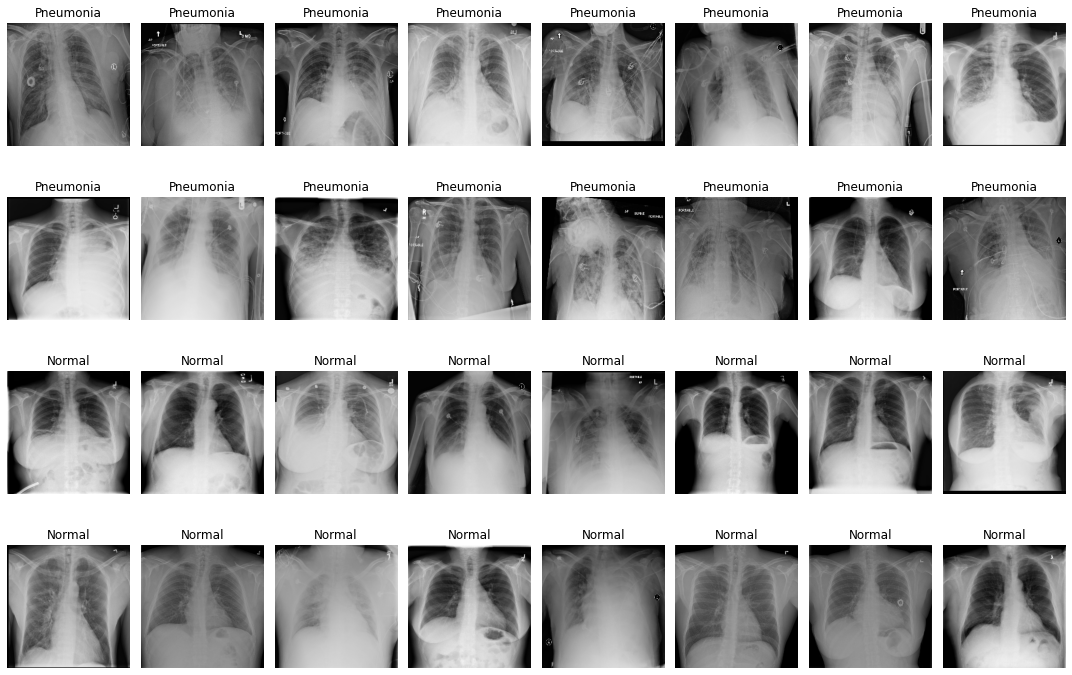

In [5]:
X, y = next(iter(eda_dataset))
f, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 10))
f.subplots_adjust(wspace=0, hspace=0.05)

for i, (img, label) in enumerate(zip(X, y)):
    r, c = i // 8, i % 8
    axes[r][c].imshow(img)
    axes[r][c].axis('off')
    axes[r][c].set_aspect('equal')
    axes[r][c].set_title('Pneumonia' if label.numpy() else 'Normal')

f.tight_layout()
plt.savefig('./plots/cutout_example.png')
plt.show()

# Training function

In [6]:
def train(run_num):
    # train/test split (DO NOT MODIFY)
    all_tfrecords = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR)]
    all_tfrecords.sort(key=lambda x: int(x.split('_')[0].strip('tfrecords\\shard')))
    train_val, test = train_test_split(all_tfrecords, test_size=TEST_SIZE, random_state=SEED)
    kf = KFold()

    # test data setup (DO NOT MODIFY)
    test_dataset = tf.data.TFRecordDataset(np.asarray(test))
    test_dataset = test_dataset.map(partial(parse_example, 
                                            data_aug = False,
                                            shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)
    test_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(test))

    test_labels = np.zeros((test_samples, ), dtype=np.uint8)
    for i, (_, label) in enumerate(test_dataset):
        test_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = label

    # Just train on 1 fold if not CV_MODE
    for fold, (tr_idx, val_idx) in enumerate(kf.split(train_val)):

        train_dataset = tf.data.TFRecordDataset(np.asarray(train_val)[tr_idx])
        # call cache before data aug! Otherwise the aug only applied for first epoch
        train_dataset = train_dataset.cache().map(partial(parse_example, 
                                                  data_aug = DATA_AUG,
                                                  shape=IMAGE_SIZE)).shuffle(2048).prefetch(AUTOTUNE).batch(BATCH_SIZE).repeat(NUM_EPOCHS)
        train_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(train_val)[tr_idx])

        valid_dataset = tf.data.TFRecordDataset(np.asarray(train_val)[val_idx])
        valid_dataset = valid_dataset.map(partial(parse_example, 
                                                  data_aug = False,
                                                  shape=IMAGE_SIZE)).prefetch(AUTOTUNE).batch(BATCH_SIZE)
        valid_samples = sum(int(x.split('.')[0].split('_')[1]) for x in np.asarray(train_val)[val_idx])

        valid_labels = np.zeros((valid_samples, ), dtype=np.uint8)
        for i, (_, label) in enumerate(valid_dataset):
            valid_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = label

        # Interval evaluation callback
        saved_model_name = os.path.join(MODEL_DIR, f'{MODEL_NAME}_fold{fold}')
       
        ieval = IntervalEval(
            saved_model_name, 
            valid_dataset, 
            # valid_samples,
            valid_labels,
            test_dataset,
            # test_samples,
            test_labels,
            True
        )

        # csvlogger callback
        csv_logger = keras.callbacks.CSVLogger('./logs/train_log.csv', append=False)

        # Tensorboard callback
        tmp_tb_dir = os.path.join(TB_DIR, 'tmp')
        if 'tmp' in os.listdir(TB_DIR): shutil.rmtree(tmp_tb_dir)
        os.mkdir(tmp_tb_dir)
        tbCallBack = tf.keras.callbacks.TensorBoard(log_dir=tmp_tb_dir,
                                                    histogram_freq=0, 
                                                    write_graph=True, 
                                                    write_images=True)
        
        # Initiate model
        model = model_build_finetune(train_samples,
                            drop_out=DROP_OUT,
                            lr=LR, 
                            ohem_rate=OHEM_RATE, 
                            num_epochs=NUM_EPOCHS, 
                            model_name=MODEL_NAME)
        steps_per_epoch = int(np.ceil(train_samples / BATCH_SIZE))

        # Model training
        model.fit(train_dataset,
                  steps_per_epoch=steps_per_epoch,
                  validation_data = valid_dataset,
                  epochs= NUM_EPOCHS,
                  callbacks=[
                    ieval, 
                    tbCallBack, 
                    csv_logger
                    ],
                  verbose=1,
                  use_multiprocessing=True
                )
        
        # Rename the tensorboard and training log folder based on model performance (separate from other training)
        s1 = ieval.f1_name.split('\\')[1].strip('.h5')
        os.rename(tmp_tb_dir, 
                  os.path.join(TB_DIR, f"{s1}_run{run_num}_config{config_num}"))
        os.rename('./logs/train_log.csv', 
                  f"./logs/train_log_{s1}_run{run_num}_config{config_num}.csv")
        if not CV_MODE: break

    return model, ieval

In [7]:
loss_hist = []
val_loss_hist = []
BestF1Train_hist = []
BestEpoch_hist = []
BestF1Test_hist = []
for i in range(5):
    model, model_cbk = train(i)
    loss_hist.append(model_cbk.loss)
    val_loss_hist.append(model_cbk.val_loss)
    BestF1Train_hist.append(model_cbk.score_max[-1])
    BestEpoch_hist.append(model_cbk.best_epoch_f1+1)
    BestF1Test_hist.append(model_cbk.test_score[-1])

Epoch 1/6
145/145 [==============================] - ETA: 0s - loss: 0.6770
AUC: 0.76004 Precision: 0.68217 Recall: 0.76125 F1:  0.71954
F1 improved from -1.00000 to 0.71954
145/145 [==============================] - 54s 258ms/step - loss: 0.6770 - val_loss: 0.6387
Epoch 2/6
145/145 [==============================] - ETA: 0s - loss: 0.6065
AUC: 0.79379 Precision: 0.72426 Recall: 0.68166 F1:  0.70232
145/145 [==============================] - 45s 235ms/step - loss: 0.6065 - val_loss: 0.5842
Epoch 3/6
145/145 [==============================] - ETA: 0s - loss: 0.5715
AUC: 0.81553 Precision: 0.76956 Recall: 0.62976 F1:  0.69267
145/145 [==============================] - 44s 234ms/step - loss: 0.5715 - val_loss: 0.5419
Epoch 4/6
145/145 [==============================] - ETA: 0s - loss: 0.5384
AUC: 0.82873 Precision: 0.73083 Recall: 0.80796 F1:  0.76746
F1 improved from 0.71954 to 0.76746
145/145 [==============================] - 45s 235ms/step - loss: 0.5384 - val_loss: 0.5151
Epoch 5/6
1

Epoch 2/6
145/145 [==============================] - ETA: 0s - loss: 0.5212
AUC: 0.84185 Precision: 0.73077 Recall: 0.82180 F1:  0.77362
F1 improved from 0.76488 to 0.77362
145/145 [==============================] - 24s 164ms/step - loss: 0.5212 - val_loss: 0.5077
Epoch 3/6
145/145 [==============================] - ETA: 0s - loss: 0.4902
AUC: 0.84802 Precision: 0.69931 Recall: 0.87716 F1:  0.77820
F1 improved from 0.77362 to 0.77820
145/145 [==============================] - 24s 164ms/step - loss: 0.4902 - val_loss: 0.5289
Epoch 4/6
145/145 [==============================] - ETA: 0s - loss: 0.4702
AUC: 0.85614 Precision: 0.74882 Recall: 0.82007 F1:  0.78282
F1 improved from 0.77820 to 0.78282
145/145 [==============================] - 24s 164ms/step - loss: 0.4702 - val_loss: 0.4740
Epoch 5/6
145/145 [==============================] - ETA: 0s - loss: 0.4442
AUC: 0.86149 Precision: 0.77835 Recall: 0.78374 F1:  0.78103
145/145 [==============================] - 24s 163ms/step - loss: 0.

In [8]:
print(BestF1Train_hist)
print(BestF1Test_hist)
print(BestEpoch_hist)

[0.7674609695973706, 0.7534965034965034, 0.7886597938144331, 0.7419354838709679, 0.782824112303881]
[0.7910447761194029, 0.7685325264750378, 0.7864823348694316, 0.7382753403933433, 0.8012232415902141]
[4, 6, 5, 5, 4]


In [9]:
loss_hist_np = np.asarray(loss_hist)
val_loss_hist_np = np.asarray(val_loss_hist)
BestF1Train_hist_np = np.asarray(BestF1Train_hist)
BestF1Test_hist_np = np.asarray(BestF1Test_hist)
print(loss_hist_np)
print(val_loss_hist_np)
loss_hist_mean = np.mean(loss_hist_np, axis=0)
val_loss_hist_mean = np.mean(val_loss_hist_np, axis=0)
BestF1Train_hist_mean = np.mean(BestF1Train_hist_np)
BestF1Test_hist_mean = np.mean(BestF1Test_hist_np)
print(loss_hist_mean)
print(val_loss_hist_mean)
print(f"Mean of BestF1ValidationScore {NUM_EPOCHS}epochs over 5 runs: {BestF1Train_hist_mean}")
print(f"Mean of BestF1TestScore {NUM_EPOCHS}epochs over 5 runs: {BestF1Test_hist_mean}")

[[0.67704636 0.60646427 0.57153082 0.53837126 0.51150465 0.4967908 ]
 [0.67383569 0.61480588 0.56825823 0.53116226 0.51440752 0.50090921]
 [0.57401836 0.51005822 0.4855893  0.44381973 0.40581304 0.36616617]
 [0.68863523 0.65721202 0.61216229 0.57301295 0.55373126 0.54022801]
 [0.62076014 0.52121252 0.49017596 0.47015965 0.44421539 0.41411528]]
[[0.63868946 0.58417803 0.5418824  0.5151397  0.49929017 0.49760392]
 [0.6273917  0.52767509 0.53411406 0.51952487 0.50833398 0.49890432]
 [0.52855867 0.51105899 0.47540432 0.47640368 0.45026889 0.45309719]
 [0.66257477 0.6135605  0.58140475 0.57295233 0.54009533 0.54376352]
 [0.57142442 0.50774467 0.52888083 0.47398475 0.46236911 0.46446851]]
[0.64685916 0.58195058 0.54554332 0.51130517 0.48593437 0.46364189]
[0.6057278  0.54884346 0.53233727 0.51160107 0.4920715  0.49156749]
Mean of BestF1ValidationScore 6epochs over 5 runs: 0.7668753726166313
Mean of BestF1TestScore 6epochs over 5 runs: 0.777111643889486


In [10]:
config_num

1

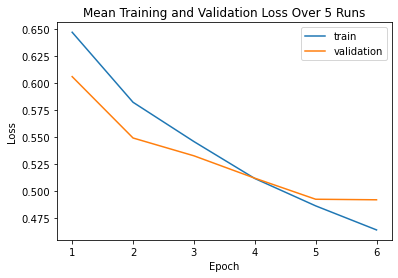

In [11]:
plt.plot(range(1, NUM_EPOCHS+1), loss_hist_mean, label='train')
plt.plot(range(1, NUM_EPOCHS+1), val_loss_hist_mean, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Mean Training and Validation Loss Over 5 Runs' )
plt.legend()
plt.savefig(f"./plots/6Epochs_AverageLoss_Config{config_num}.png")
plt.show()

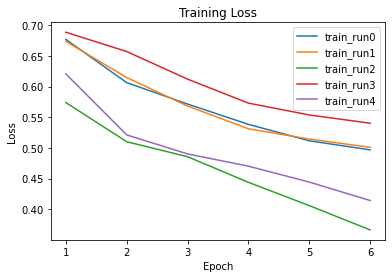

In [12]:
for i in range(5):
    plt.plot(range(1, NUM_EPOCHS+1), loss_hist[i], label=f"train_run{i}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig(f"./plots/6Epochs_TrainLoss_5Runs_Config{config_num}.png")
plt.show()

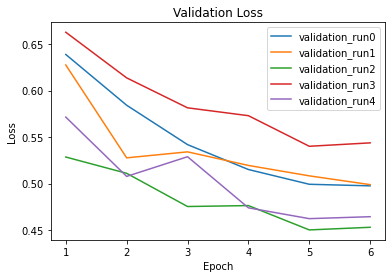

In [13]:
for i in range(5):
    plt.plot(range(1, NUM_EPOCHS+1), val_loss_hist[i], label=f"validation_run{i}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.savefig(f"./plots/6Epochs_ValidationLoss_5Runs_Config{config_num}.png")
plt.show()

In [14]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Training and validation loss curve for specific run

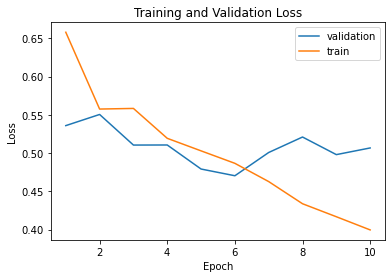

In [12]:
df_train_hx = pd.read_csv("./logs/train_log_vgg16_fold0_val78040_test75621_FineTuningWoLastLayerPreTuning.csv")

plt.plot(range(1, NUM_EPOCHS+1), df_train_hx['val_loss'], label='validation')
plt.plot(range(1, NUM_EPOCHS+1), df_train_hx['loss'], label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('./plots/train_log_vgg16_fold0_val78040_test75621_FineTuningWoLastLayerPreTuning.png')
plt.show()